In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os
import random
def set_seed(seed_value):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

SEED = 42
set_seed(SEED)

def load_images_from_directory(directory):
    images = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            # Check if the file is an image
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, filename)
                image = load_img(img_path, target_size=(128, 128))  # Resize image
                image_array = img_to_array(image)  # numpy array
                image_array /= 255.0  # Normalize 0 to 1 
                images.append(image_array)
    images = np.array(images)
    return images

x = []
x.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainA"))
x.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainA"))
x.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainA"))
x.extend(load_images_from_directory("/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/input"))

y = []
y.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainB"))
y.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainB"))
y.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainB"))
y.extend(load_images_from_directory("/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/GT"))

x_array = np.array(x)
y_array = np.array(y)

print(f"x_array shape: {x_array.shape}")
print(f"y_array shape: {y_array.shape}")

indices = np.arange(x_array.shape[0])
np.random.shuffle(indices)
x_array = x_array[indices]
y_array = y_array[indices]

# Split into training and validation 
split_idx = int(0.8 * len(x_array))
train_data, val_data = x_array[:split_idx], x_array[split_idx:]
train_targets, val_targets = y_array[:split_idx], y_array[split_idx:]

print(f"Train data shape: {train_data.shape}, Train targets shape: {train_targets.shape}")
print(f"Validation data shape: {val_data.shape}, Validation targets shape: {val_targets.shape}")

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, Conv2DTranspose, Add, Activation
from tensorflow.keras.optimizers import Adam
# Conv2DTranspose : Upsampling to increases resolution 
# Stride : downsampling 
def build_uice2net(input_shape_rgb, input_shape_hsv):
    # RGB Path
    rgb_input = Input(shape=input_shape_rgb, name="RGB_Input")
    x_rgb = Conv2D(256, kernel_size=3, strides=1, padding="same", activation="relu")(rgb_input)
    x_rgb = Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(x_rgb)
    x_rgb = Conv2D(64 , kernel_size=3, strides=2, padding="same", activation="relu")(x_rgb)
    x_rgb = Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu")(x_rgb)
    # transpose back to the og image 
    rgb_output = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu")(x_rgb)
    rgb_output = Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh")(rgb_output)

    # HSV Path
    hsv_input = Input(shape=input_shape_hsv, name="HSV_Input") # focus on a single channel (V -> brigthness )
    x_hsv = Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu")(hsv_input)
    x_hsv = Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x_hsv)
    x_hsv = Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(x_hsv)
    x_hsv = Conv2D(64, kernel_size=3, strides=1, padding="same", activation="relu")(x_hsv)
    hsv_output = Conv2DTranspose(32, kernel_size=4, strides=2, padding="same", activation="relu")(x_hsv)
    hsv_output = Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", activation="tanh")(hsv_output)

    # Combine RGB and HSV outputs
    hsv_broadcasted = Activation("linear")(hsv_output)
    hsv_broadcasted = Add()([hsv_broadcasted, hsv_broadcasted, hsv_broadcasted])  # Broadcast HSV channels to match RGB (3 channels)
    combined_output = Add(name="Combined_Output")([rgb_output, hsv_broadcasted]) # produce enhanced image.

    # Model definition
    model = Model(inputs=[rgb_input, hsv_input], outputs=combined_output, name="UICE2Net")
    return model

# Model compilation
input_shape_rgb = (128, 128, 3)  # Example input shape for RGB images
input_shape_hsv = (128, 128, 1)  # Example input shape for HSV images
model = build_uice2net(input_shape_rgb, input_shape_hsv)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

# Model summary
model.summary()


Model: "UICE2Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ HSV_Input (InputLayer)    │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │          1,280 │ HSV_Input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ RGB_Input (InputLayer)    │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         73,792 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 256)  │          7,168 │ RGB_Input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │        295,040 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 64)     │         73,792 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         73,792 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 64, 32)     │         32,800 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 128, 128, 1)    │            513 │ conv2d_transpose_2[0]… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 64)     │        131,136 │ conv2d_3[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 1)    │              0 │ conv2d_transpose_3[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 3)    │          3,075 │ conv2d_transpose[0][0] │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 1)    │              0 │ activation[0][0],      │
│                           │                        │                │ activation[0][0],      │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Combined_Output (Add)

 Total params: 840,100 (3.20 MB)

 Trainable params: 840,100 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
x_dataset = tf.data.Dataset.from_tensor_slices(x_array)

def prepare_data(image):
    # RGB image
    rgb = image  # Original RGB image
    hsv = tf.image.rgb_to_hsv(image)[..., 2:3]  # Keep only the V channel
    return (rgb, hsv), rgb  # Input: (RGB, HSV), Target: RGB
    
batch_size = 16
train_dataset = x_dataset.map(prepare_data).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_split = 0.2
val_size = int(len(x_array) * val_split)
train_dataset = train_dataset.skip(val_size)
val_dataset = train_dataset.take(val_size)


In [4]:
##### Combine RGB and HSV inputs for model training
def generator(input_data, target_data):
    while True:
        for i in range(len(input_data)):
            rgb_batch = np.expand_dims(input_data[i], axis=0)  # Add batch dimension
            hsv_batch = np.expand_dims(rgb_batch.mean(axis=-1), axis=-1)  # HSV V-channel taking the mean along the last axis
            target_batch = np.expand_dims(target_data[i], axis=0)  # Ground truth 
            yield (rgb_batch, hsv_batch), target_batch  


# Create training and validation generators
train_generator = generator(train_data, train_targets)
val_generator = generator(val_data, val_targets)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data),
    epochs=50,
    validation_steps=len(val_data),
    validation_data=val_generator
)






Epoch 1/50
13033/13033 ━━━━━━━━━━━━━━━━━━━━ 106s 8ms/step - loss: 0.0180 - mae: 0.0988 - val_loss: 0.0112 - val_mae: 0.0796
Epoch 2/50
13033/13033 ━━━━━━━━━━━━━━━━━━━━ 100s 8ms/step - loss: 0.0103 - mae: 0.0760 - val_loss: 0.0104 - val_mae: 0.0767
Epoch 3/50
13033/13033 ━━━━━━━━━━━━━━━━━━━━ 100s 8ms/step - loss: 0.0095 - mae: 0.0732 - val_loss: 0.0099 - val_mae: 0.0745
Epoch 4/50
13033/13033 ━━━━━━━━━━━━━━━━━━━━ 100s 8ms/step - loss: 0.0092 - mae: 0.0719 - val_loss: 0.0100 - val_mae: 0.0748
Epoch 5/50
13033/13033 ━━━━━━━━━━━━━━━━━━━━ 101s 8ms/step - loss: 0.0090 - mae: 0.0712 - val_loss: 0.0096 - val_mae: 0.0739
Epoch 6/50
13033/13033 ━━━━━━━━━━━━━━━━━━━━ 101s 8ms/step - loss: 0.0088 - mae: 0.0704 - val_loss: 0.0092 - val_mae: 0.0720
Epoch 7/50
13033/13033 ━━━━━━━━━━━━━━━━━━━━ 101s 8ms/step - loss: 0.0087 - mae: 0.0699 - val_loss: 0.0090 - val_mae: 0.0711
Epoch 8/50
13033/13033 ━━━━━━━━━━━━━━━━━━━━ 101s 8ms/step - loss: 0.0086 - mae: 0.0693 - val_loss: 0.0091 - val_mae: 0.0721
Epoch 9/

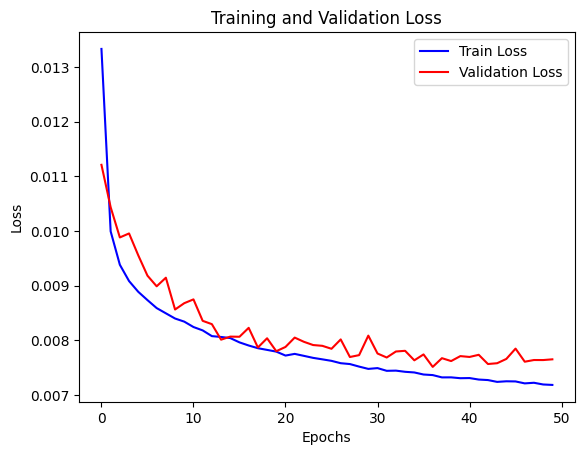

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss' , color = 'blue')
plt.plot(history.history['val_loss'], label='Validation Loss' , color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [8]:
def enhance_images(model, images):
    enhanced = model.predict(images)
    return enhanced


In [9]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr # image quality to signal-to-noise 
import numpy as np
import pandas as pd

# Function to calculate MSE
def calculate_mse(img1, img2):
    return np.mean((img1 - img2) ** 2)
# img1 : enhaced 
# img2 : og image

# Generate evaluation metrics
def evaluate_images(model, original_images, target_images, num_images=5):
    metrics = []
    enhanced_images = []

    for i in range(num_images):
        # Get a single image
        original = original_images[i]
        target = target_images[i % len(target_images)]  # Ensure target is not identical to original
        
        # Prepare HSV input
        hsv = np.expand_dims(original.mean(axis=-1), axis=-1)
        
        # Predict enhanced image
        enhanced = model.predict([[original[np.newaxis]], [hsv[np.newaxis]]])[0]
        enhanced_images.append(enhanced)

        # Calculate metrics
        mse_original = calculate_mse(enhanced, original)
        mse_target = calculate_mse(enhanced, target)

        # Explicitly specify data_range and win_size
        data_range = enhanced.max() - enhanced.min()
        psnr_original = psnr(enhanced, original, data_range=data_range)
        psnr_target = psnr(enhanced, target, data_range=data_range)

        # Set win_size to the minimum odd value that fits within image dimensions
        win_size = min(original.shape[0], original.shape[1], 7)
        ssim_original = ssim(
            enhanced, original, data_range=data_range, win_size=win_size, channel_axis=-1
        )
        ssim_target = ssim(
            enhanced, target, data_range=data_range, win_size=win_size, channel_axis=-1
        )

        metrics.append({
            'Image': i + 1,
            'MSE (Original)': mse_original,
            'MSE (Target)': mse_target,
            'PSNR (Original)': psnr_original,
            'PSNR (Target)': psnr_target,
            'SSIM (Original)': ssim_original,
            'SSIM (Target)': ssim_target,
        })

    return metrics, enhanced_images

# Evaluate and display results
num_images = 5 
metrics, enhanced_images = evaluate_images(model, val_data, val_targets, num_images=num_images)

df_metrics = pd.DataFrame(metrics)
print(df_metrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
   Image  MSE (Original)  MSE (Target)  PSNR (Original)  PSNR (Target)  \
0      1        0.011931      0.004668        20.541178      24.616271   
1      2        0.018867      0.005177        16.975593      22.592103   
2      3        0.020931      0.005043        17.065662      23.246523   
3      4        0.010589      0.002999        19.983707      25.462383   
4      5        0.008440      0.006502        20.219152      21.352119   

   SSIM (Original)  SSIM (Target)  
0         0.807339       0.813869  
1         0.885352       0.897777  
2         0.819098       0.844715  
3         0.892185       0.883918  
4         0.876497       0.809740  


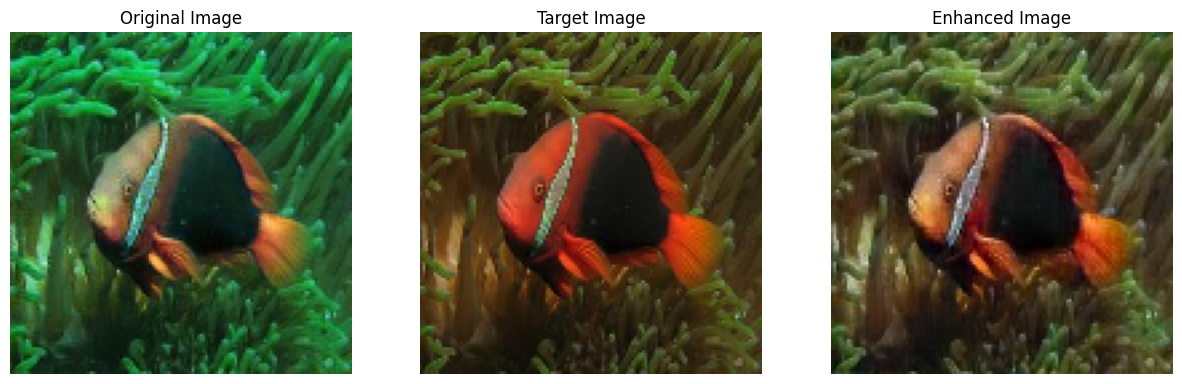

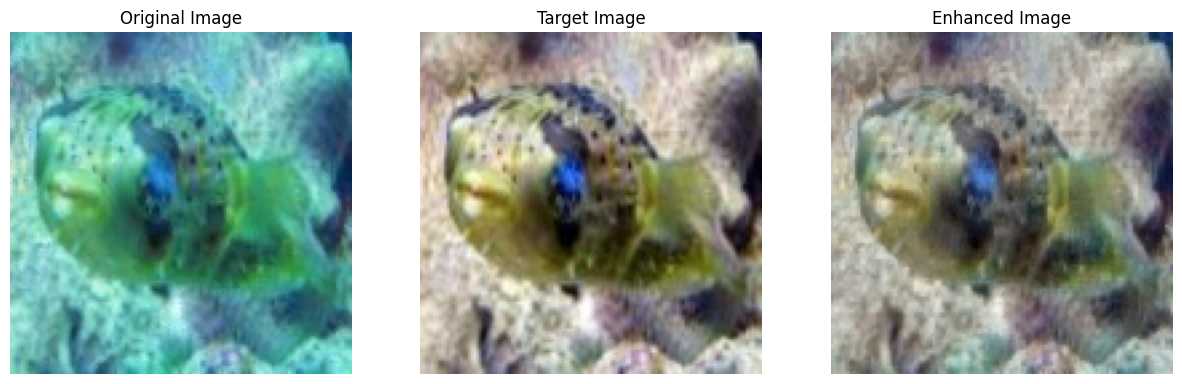

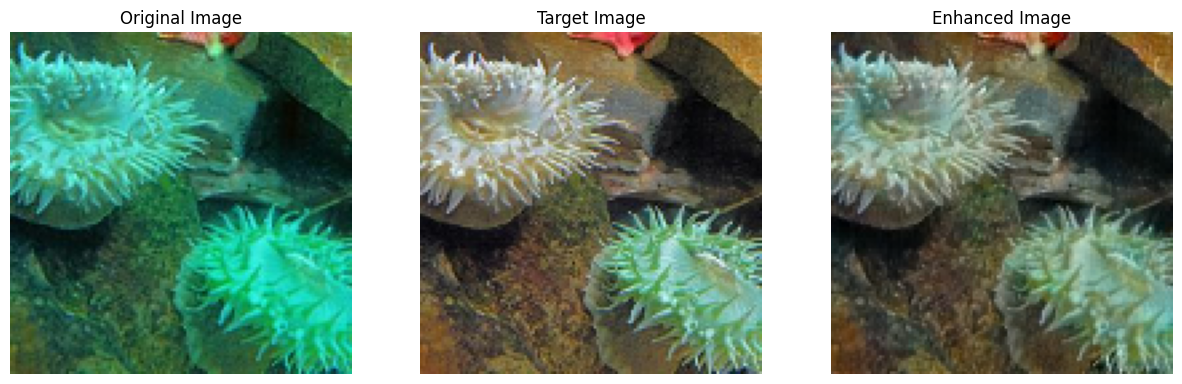

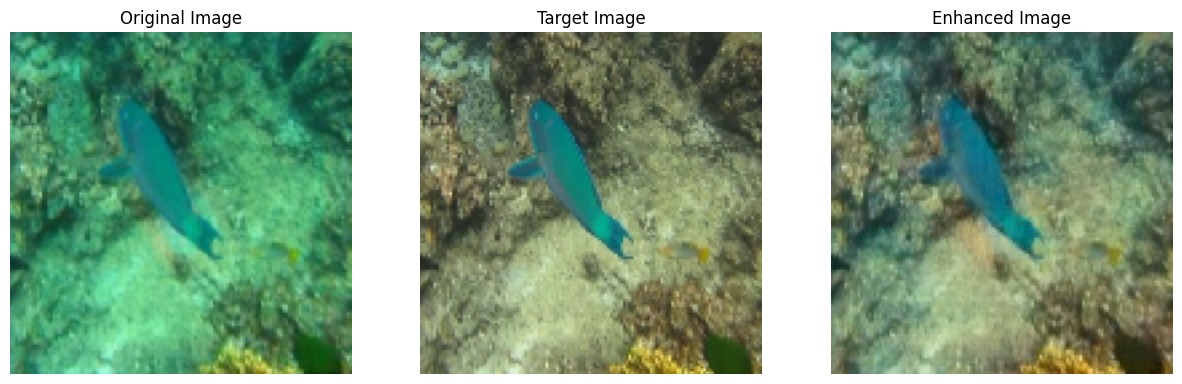

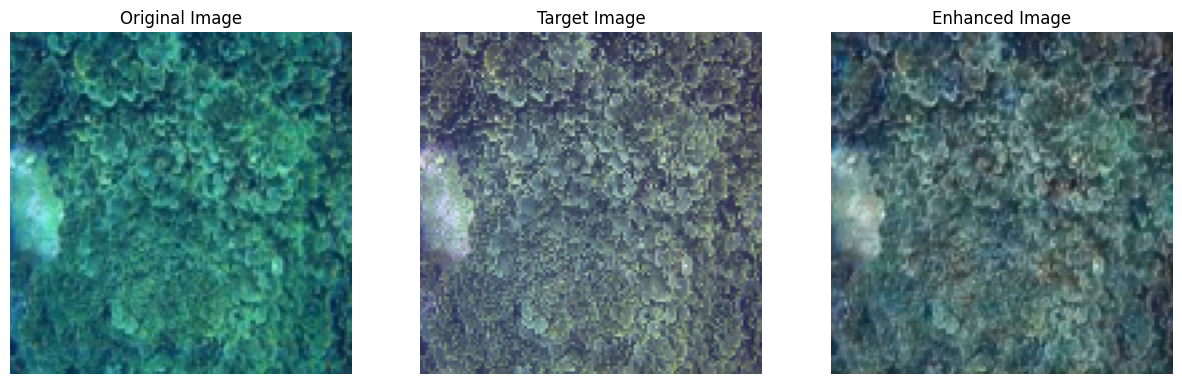

In [10]:
import matplotlib.pyplot as plt
def visualize_results(original_images, target_images, enhanced_images, num_images=5):
    for i in range(num_images):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(original_images[i])
        plt.axis('off')
  
        plt.subplot(1, 3, 2)
        plt.title('Target Image')
        plt.imshow(target_images[i % len(target_images)])
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Enhanced Image')
        plt.imshow(enhanced_images[i])
        plt.axis('off')
        
        plt.show()

visualize_results(val_data, val_targets, enhanced_images, num_images=5)


In [11]:
val_loss, val_mae = model.evaluate([val_data, val_data[:, :, :, :1]], val_targets, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Mean Absolute Error: {val_mae:.4f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0503 - mae: 0.1757
Validation Loss: 0.0501
Validation Mean Absolute Error: 0.1756


In [13]:
model.save('uice2net_model_final.h5')